In [928]:
import os
import numpy as np
import scipy as sp
import scipy.io
from scipy.linalg import expm
import pandas as pandas
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from Nexis_functions import heatmap, total_tau_plot, normalize_by_l2_norm, mse_matrix
from functools import partial
from Nexis_model_seedop import run_Nexis
from scipy.stats import pearsonr
import seaborn as sns
import heapq



## Preparing Inputs

In [929]:
# Prepare connectivity matrix

# Load connectivity matrix
connectivity_df = pandas.read_csv('Connectivity matrix.csv')

# List of striatal regions to exclude from further analysis 
regions_to_exclude = ['Left-Pallidum','Right-Pallidum','Left-Accumbens-area','Right-Accumbens-area','Right-Putamen','Left-Putamen','Right-Caudate','Left-Caudate']

# Find indices (in the region order of the connectivity matrix) for regions to exclude 
excluded_indices = [connectivity_df.columns.get_loc(region) for region in regions_to_exclude]

# Delete striatal regions 
connectivity_df = connectivity_df.drop(index = excluded_indices)
connectivity_df = connectivity_df.drop(columns=regions_to_exclude)

# Convert connectivity matrix to a nROI x nROI array
connectivity_matrix = connectivity_df.values

# Normalize connectivity matrix (divide by max because min is already 0 in diagonal entries)
max = np.max(connectivity_matrix)
connectivity_matrix = connectivity_matrix / max

In [930]:
# Load DK regional volumes 
regional_volumes = pandas.read_csv('DK_ROI_volumes.csv')

# Convert to an 1 x nROI array 
regional_volumes = regional_volumes.values

# Converting region order of DK to that of connectivity matrix
new_order_DK = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67]
regional_volumes_reordered = regional_volumes[new_order_DK, :]

# Delete striatal regions
regional_volumes_excluded = np.delete(regional_volumes_reordered,excluded_indices)

# Define the number of regions  
nROI = 86 - len(regions_to_exclude)

# Order of regions (left subcortex, right subcortex, left cortex, right cortex)
regions = ['Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate','ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal','ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula', 'ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus',	'ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']

In [1021]:
# Run on either individual subjects (1) or whole cohort (0) (SET HERE)
individual = 1

In [1022]:
# Define inputs to NEXIS

C_ = connectivity_matrix  # Connectivity matrix (nROI x nROI)
U_ = np.zeros((nROI, 1)) # Cell type matrix (nROI x nTypes)/ gene_data_reordered
t_vec_ = np.linspace(0, 18, 19)  # Time vector in terms of stages outputted by EBM (16 stages) # CHANGE LATER: 100 time points once time vs. stage relationship has been specified
w_dir_ = 0  # Since I don't care about directionality, set to 0 which overwrites s as 0.5
volcorrect_ = 1  # Binary flag set to 0 if not correcting for volume, set to 1 if correcting for volume and add regional volume data to regional_volumes
region_volumes_ = regional_volumes_excluded  # Regional volumes for normalization (nROI x 1)
logistic_term_ = 0 # Binary flag set to 1 to run with logistic term and 0 to run without

## Load Patient Data

In [1023]:
# Upload patient data
patient_data = pandas.read_csv('EBM stage + tau/Cross-sectional stage and regional tau - version 9.csv')

# Avoid repeating any RIDS and remove controls
#patient_data = patient_data[patient_data['Diagnosis'] != 'CN'] (only do this is running on cohort)
unique_rids = patient_data['RID'].unique()

demo = patient_data.columns[:4]
tau = patient_data.columns[4:]

# Reorder regions to match region order of connectivity matrix
new_order_ADNI = [68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]
reordered_columns = tau[new_order_ADNI]
new_column_order = list(demo) + list(reordered_columns)
patient_data = patient_data[new_column_order]

# Delete striatal regions 
patient_data = patient_data.drop(regions_to_exclude, axis = 1)

if individual:
    RID = 112 #EDIT PATIENT RID MANUALLY HERE
    patient = patient_data[patient_data['RID'] == RID] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]
    # LATER: DEFINE IN TERMS OF TIME WHERE TIME vs. STAGE RELAITONSHIP IS SIGNMOIDAL

    # Define patient tau data
    patient_tau = patient.iloc[:,4:]

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T 


## Seed Optimization

In [1013]:
# Determining optimal lambda

nexis_model = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_,
                        region_volumes_=region_volumes_, logistic_term_=1)

# Create data from for lambda and MSE
column_names_1 = ['L1 cost', 'MSE', 'Lambda', 'optimized initial vector']
L1_mse = pandas.DataFrame(columns = column_names_1)

for Lambda in np.arange(0, 0.02, 0.001):

        # Define a function that runs Nexis and calculates the MSE 
        def Nexis_MSE(params, patient_tau):
                
                param1 = params # param1 = initial vector

                # Initialize run_Nexis class 
                nexis_model_mse = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                                volcorrect_=volcorrect_, region_volumes_=region_volumes_, logistic_term_=1)

                # Parameters for simulate_nexis method
                parameters = [0.05682783098035397, 1.0099199088257873, 1.0, 0.5, 0.0, 0.07, 20.000003789393187, param1]  # [alpha, beta, gamma, s, b, p , k, inital vector] 
                # optimized params version 1: 0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07, 20.000567683872493
                # optimized params final: 0.05682783098035397, 1.0099199088257873, 1.0, 0.5, 0.0, 0.07, 20.000003789393187

                # Call the simulate_nexis method with the parameters
                Y = nexis_model_mse.simulate_nexis(parameters)

                # For optimization, only take stages from Y that correspond to patient's stages 
                Y_edited = Y[:, stages] 

                error = mse_matrix(patient_tau,Y_edited) + Lambda * param1.sum()
                
                return error

        #Optimize parameters by minimizing MSE between patient data and Y
        custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau)

        # Initial guesses for initial vector
        seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # Manually edit guess for seeding region here
        seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]
        array_length = nROI
        init_guess = np.zeros(array_length)
        init_guess[seeding_indices[0]] = 1 
        init_guess[seeding_indices[1]] = 1

        # Bounds for initial vector
        bounds = [(0, 3) for _ in range(nROI)]

        # Perform the optimization
        result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B',
                        options={'ftol': 1e-3, 'gtol': 1e-3,'maxiter': 1000}) 
        
        if result.success:
                optimized_initial_vec = result.x
                optimized_initial_vec = optimized_initial_vec.tolist()
        
        # Run Nexis    
        parameters =  [0.26578466302222054, 0.4901505014988503, 1.0, 0.5, 0.0, 0.07, 20.000567683872493, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE
        Y = nexis_model.simulate_nexis(parameters) 
        Y_edited = Y[:, stages]
        
        # Calculate MSE
        mse = mse_matrix(patient_tau, Y_edited)
        
        # Create data frame for the subject
        sub_df = pandas.DataFrame([[Lambda  * sum(optimized_initial_vec)] + [mse] + [Lambda] + [optimized_initial_vec]], columns=column_names_1)

        # Concatenate the original DataFrame with the new DataFrame
        L1_mse = pandas.concat([L1_mse, sub_df], ignore_index=True)

# Plot MSE vs. lambda
L1_mse = L1_mse.sort_values(by='L1 cost')
plt.figure(figsize=(10, 6))
plt.plot(L1_mse.iloc[:,0:1], L1_mse.iloc[:,1:2], marker='o', linestyle='-', color='b', label='Data Line')

# Add labels and title
plt.xlabel('L1 cost')
plt.ylabel('MSE')
plt.title('MSE vs. L1 cost')

# Show the plot
plt.show()

KeyboardInterrupt: 

In [1026]:
# SET LAMBDA HERE (for L1 regularization)
Lambda = 0.01 

# Define cost function
def Nexis_MSE(params, patient_tau, stages):
        
        param1 = params # param1 = initial vector

        # Initialize run_Nexis class 
        nexis_model_mse = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                            volcorrect_=volcorrect_, region_volumes_=region_volumes_, logistic_term_=1)

        # Parameters for simulate_nexis method
        parameters = [0.574, 0.539, 1.0, 0.5, 0.0, 0.0, 50.0, param1]  # [alpha, beta, gamma, s, b, p , k, inital vector] 
        # param op 1: 
        # param op 2: 
        # param op 3: 0.574, 0.539

        # Call the simulate_nexis method with the parameters
        Y = nexis_model_mse.simulate_nexis(parameters)

        # For optimization, only take stages from Y that correspond to patient's stages 
        if individual:
                Y_edited = Y[:, stages] 
                 # Calculate R
                corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())

                error = mse_matrix(patient_tau,Y_edited) + 0.5 * (1- corr_coeff) + Lambda * param1.sum()
        else:
                error_overall = 0
                for rid in unique_rids:
                        patient = patient_data[patient_data['RID'] == rid] 
                        stages = patient['ml_stage'].tolist()
                        stages = [int(x) for x in stages]
                        patient_tau = patient.iloc[:,4:]
                        patient_tau = patient_tau.to_numpy()
                        patient_tau = patient_tau.T 

                        Y_edited = Y[:, stages] 
                        
                        # Check for constant input arrays
                        if np.all(patient_tau == patient_tau[0]) or np.all(Y_edited == Y_edited[0]):
                                return 1e10
                        
                        corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
                        error_individual = mse_matrix(patient_tau,Y_edited) + 0.5 * (1- corr_coeff) + Lambda * param1.sum()
                        error_overall = error_overall + error_individual

                error = error_overall
       
        return error

In [1027]:
if individual:
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau, stages=stages)
else: 
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau, stages=0)

# Initial guesses for initial vector
seeding_locations = ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'] # Manually edit guess for seeding region here
seeding_indices = [regions.index(item) for item in seeding_locations if item in seeding_locations]
array_length = nROI
init_guess = np.zeros(array_length)
init_guess[seeding_indices[0]] = 1 
init_guess[seeding_indices[1]] = 1

# Bounds for initial vector
bounds = [(0, 3) for _ in range(nROI)]

# Perform the optimization
result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B',
                      options={'ftol': 1e-3, 'gtol': 1e-3,'maxiter': 1000}) 

# Check the results
if result.success:
    optimized_initial_vec = result.x
    optimized_initial_vec = optimized_initial_vec.tolist()

    print(f"Optimization successful. Optimized initial vector: {optimized_initial_vec}")
else:
    print("Optimization failed.", result.message)
    

Optimization successful. Optimized initial vector: [0.0, 0.0, 0.0409865474012114, 0.033715297976002895, 0.0, 0.0, 0.00011342886152560995, 0.0, 0.0, 0.0, 0.0, 0.0, 7.94080411808815e-06, 0.0, 0.0, 0.01944932193352361, 0.0, 0.017301293614850468, 0.0, 0.0, 0.007762539964932764, 0.0, 0.0, 0.0, 0.003236633345069344, 0.0, 5.266361835810113e-05, 0.0, 0.0, 0.0, 7.400328970735616e-06, 0.0, 2.2944412795129556e-05, 0.0, 0.0, 1.87018790367924e-05, 1.3578490402544297e-05, 2.838262783392638e-05, 0.0, 0.00023142993575456794, 0.0, 0.018244739628809226, 0.0, 0.0, 0.0, 4.451699921322195e-06, 0.00015156200565273343, 0.0, 0.3624041077461779, 0.0, 7.831417724149607e-05, 0.0, 0.0, 0.0, 0.02325023045469282, 0.0, 0.0, 8.402168142665707e-05, 0.0, 2.802293260102008e-05, 2.1105679349962866e-05, 0.0, 1.662628732584585e-05, 0.0, 4.8016952385410806e-05, 2.1447355036504807e-05, 8.24779630737171e-05, 0.0, 4.812892907975757e-06, 0.0011769068959174608, 0.0007317948342110361, 0.0, 0.0, 4.007582665210307e-05, 0.0, 0.0, 0.

Top seed regions: ['ctx-rh-entorhinal' 'Left-Hippocampus' 'Left-Amygdala'
 'ctx-rh-lateralorbitofrontal' 'ctx-lh-fusiform']


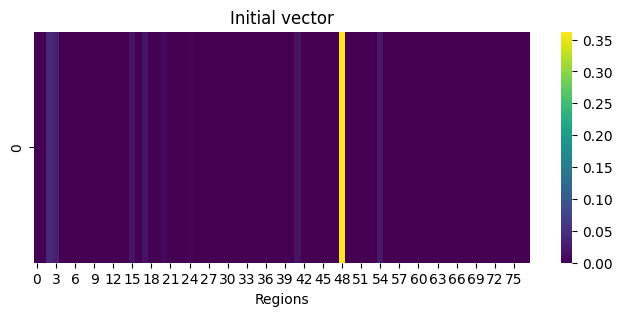

In [1028]:
# Threshold regional seed values to increase sparcity
num_seeds = 6 # SET HERE number of highest tau regions retained
thresholded_init_vec = optimized_initial_vec.copy()
top_values = heapq.nlargest(num_seeds, thresholded_init_vec)
thresholded_init_vec = [x if x in top_values else 0 for x in thresholded_init_vec]

# Create a heatmap of initial vector
plt.figure(figsize=(8, 3)) 
sns.heatmap([optimized_initial_vec], cmap='viridis')
# Add labels and title
plt.xlabel('Regions')
plt.title('Initial vector')

# Print highest tau seed regions
top_seed_values = sorted(optimized_initial_vec, reverse=True)[:5]
top_indices = sorted(range(len(optimized_initial_vec)), key=lambda i: optimized_initial_vec[i], reverse=True)[:5]
regions_array = np.array(regions)
top_seeds = regions_array[top_indices]
print('Top seed regions: ' + str(top_seeds))

## Running Nexis

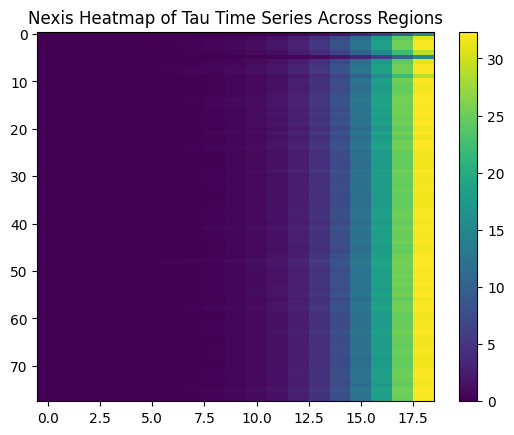

In [1029]:
# Initialize run_Nexis class 
nexis_model = run_Nexis(C_=C_, U_=U_, t_vec_=t_vec_, w_dir_=w_dir_,
                        volcorrect_=volcorrect_,
                        region_volumes_=region_volumes_, logistic_term_=1)

# Parameters for simulate_nexis method
parameters =  [0.574, 0.539, 1, 0.5, 0.0, 0.0, 50.0, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE

# Call the simulate_nexis method with the parameters
Y = nexis_model.simulate_nexis(parameters)

if individual:  
    # Take stages from Y that correspond to patient's stages 
    Y_edited = Y[:, stages]

# Plot heatmap of Y
plt = heatmap('baseline',Y)

## Check Results

In [1030]:
if individual:
    # Calculate MSE between E(t) and Y
    mse = mse_matrix(patient_tau, Y_edited)
    print('Mean squared error: ' + str(mse))

    # Calculate R (only relevant with longitudinal data)
    R, p_value = pearsonr(Y_edited.flatten(), patient_tau.flatten())
    print('Pearsons R: ' + str(R))


Mean squared error: 0.012089071239251967
Pearsons R: 0.5793392509137414


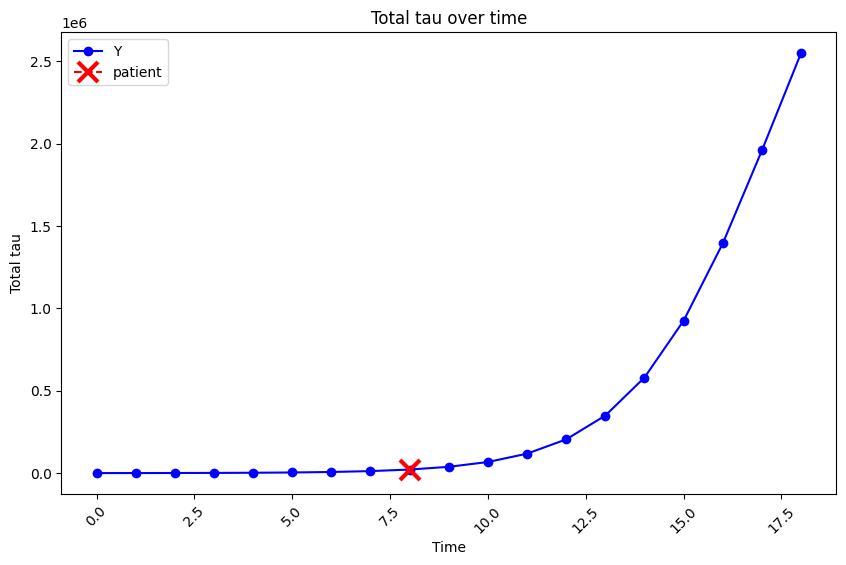

In [1031]:
# Plot total tau over time for patient tau and Y_edited

if individual:

    # Volume correction
    regional_volumes_array = np.array(regional_volumes_excluded)
    regional_volumes_array = regional_volumes_array.reshape((78,1))
    tau_mass_Y = regional_volumes_array * Y
    total_tau_Y = np.sum(tau_mass_Y, axis=0)
    patient_tau = patient_tau.reshape(78,1)
    tau_mass_patient = regional_volumes_array * patient_tau
    total_tau_patient = np.sum(tau_mass_patient, axis=0)

    time_points_Y = np.linspace(0, 18, 19)

    plt.figure(figsize=(10, 6))

    # Plot total_tau_Y
    plt.plot(time_points_Y, total_tau_Y, marker='o', linestyle='-', color='b', label= 'Y')  

    # Plot total_tau_patient on the same graph
    plt.plot(stages, total_tau_patient, marker='x', linestyle='--', color='r', label= 'patient', markersize=15, markeredgewidth=3)

    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    plt.legend()  # Add a legend to distinguish the two lines
    plt.show

else:
    # Define time points 
    time_points = np.linspace(0,18,19)

    plt.figure(figsize=(10, 6))

    # Plot Y
    total_tau_Y = np.sum(Y, axis=0)
    plt.plot(time_points, total_tau_Y, marker='o', linestyle='-', color='r', label= 'Y')  

    # Plot total tau for each subject
    patient_data.loc[:, 'Sum'] = patient_data.iloc[:, 4:].sum(axis=1)
    plt.scatter(patient_data['ml_stage'], patient_data['Sum'], color='b', label='Subjects')

    plt.title('Total tau over time') 
    plt.xlabel('Time')  # Label the x-axis
    plt.ylabel('Total tau')  # Label the y-axis
    plt.xticks(rotation=45)  # Optional: rotate x-axis labels for better readability
    plt.legend()  # Add a legend to distinguish the two lines
    plt.show

## Loop through all subjects

In [1037]:
#Create a data frame for all patients seeding patterns
column_names = ['RID', 'MSE', 'R', 'Left-Cerebellum-Cortex','Left-Thalamus-Proper','Left-Hippocampus','Left-Amygdala','Left-VentralDC','Right-Cerebellum-Cortex','Right-Thalamus-Proper','Right-Hippocampus','Right-Amygdala','Right-VentralDC','ctx-lh-bankssts','ctx-lh-caudalanteriorcingulate',	'ctx-lh-caudalmiddlefrontal','ctx-lh-cuneus','ctx-lh-entorhinal','ctx-lh-fusiform','ctx-lh-inferiorparietal','ctx-lh-inferiortemporal','ctx-lh-isthmuscingulate','ctx-lh-lateraloccipital','ctx-lh-lateralorbitofrontal','ctx-lh-lingual','ctx-lh-medialorbitofrontal','ctx-lh-middletemporal','ctx-lh-parahippocampal','ctx-lh-paracentral','ctx-lh-parsopercularis','ctx-lh-parsorbitalis','ctx-lh-parstriangularis','ctx-lh-pericalcarine','ctx-lh-postcentral','ctx-lh-posteriorcingulate','ctx-lh-precentral','ctx-lh-precuneus','ctx-lh-rostralanteriorcingulate','ctx-lh-rostralmiddlefrontal','ctx-lh-superiorfrontal','ctx-lh-superiorparietal',	'ctx-lh-superiortemporal','ctx-lh-supramarginal','ctx-lh-frontalpole','ctx-lh-temporalpole','ctx-lh-transversetemporal','ctx-lh-insula','ctx-rh-bankssts', 'ctx-rh-caudalanteriorcingulate', 'ctx-rh-caudalmiddlefrontal', 'ctx-rh-cuneus','ctx-rh-entorhinal', 'ctx-rh-fusiform','ctx-rh-inferiorparietal','ctx-rh-inferiortemporal',	'ctx-rh-isthmuscingulate','ctx-rh-lateraloccipital','ctx-rh-lateralorbitofrontal','ctx-rh-lingual','ctx-rh-medialorbitofrontal','ctx-rh-middletemporal','ctx-rh-parahippocampal','ctx-rh-paracentral','ctx-rh-parsopercularis','ctx-rh-parsorbitalis','ctx-rh-parstriangularis','ctx-rh-pericalcarine','ctx-rh-postcentral','ctx-rh-posteriorcingulate',	'ctx-rh-precentral',	'ctx-rh-precuneus','ctx-rh-rostralanteriorcingulate','ctx-rh-rostralmiddlefrontal','ctx-rh-superiorfrontal','ctx-rh-superiorparietal','ctx-rh-superiortemporal','ctx-rh-supramarginal','ctx-rh-frontalpole','ctx-rh-temporalpole','ctx-rh-transversetemporal','ctx-rh-insula']
seeding_all = pandas.DataFrame(columns=column_names)

for rid in unique_rids:

    patient = patient_data[patient_data['RID'] == rid] 

    # Define number of time points 
    num_time_points = patient.shape[0]

    # Define list with stage assingments for each time point
    stages = patient['ml_stage'].tolist()
    stages = [int(x) for x in stages]

    # Define patient tau data
    patient_tau = patient.iloc[:,4:]

    # Convert to array and transpose so dim = nROI x # of stages
    patient_tau = patient_tau.to_numpy()
    patient_tau = patient_tau.T

    # Perform the optimization
    custom_Nexis_MSE = partial(Nexis_MSE, patient_tau=patient_tau, stages=stages)

    result = minimize(custom_Nexis_MSE, init_guess, bounds=bounds, method='L-BFGS-B', 
                    options={'ftol': 1e-3, 'gtol': 1e-3, 'maxiter': 1000})
    
    if result.success:
        optimized_initial_vec = result.x
        optimized_initial_vec = optimized_initial_vec.tolist( )

    # Run Nexis    
    parameters =  [0.574, 0.539, 1, 0.5, 0.0, 0.0, 50.0, optimized_initial_vec] # [alpha, beta, gamma, s, b, p, k, initial vector] # CAN MANUALLY SET PARAMETERS HERE
    Y = nexis_model.simulate_nexis(parameters) 
    Y_edited = Y[:, stages]
    
    # Calculate MSE and R
    mse = mse_matrix(patient_tau, Y_edited)
    corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())
    
    # Create data frame for the subject
    seeding = pandas.DataFrame([[rid] + [mse] + [corr_coeff] + optimized_initial_vec], columns=column_names)

    # Concatenate the original DataFrame with the new DataFrame
    seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)

seeding_all

/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1376/2309288855.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  seeding_all = pandas.concat([seeding_all, seeding], ignore_index=True)
/var/folders/bd/p6dnm7ns0tb9glfgc_h835k40000gn/T/ipykernel_1376/139438440.py:23: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_coeff, p_value = pearsonr(patient_tau.flatten(), Y_edited.flatten())


,RID,MSE,R,Left-Cerebellum-Cortex,Left-Thalamus-Proper,Left-Hippocampus,Left-Amygdala,Left-VentralDC,Right-Cerebellum-Cortex,Right-Thalamus-Proper,...,ctx-rh-rostralanteriorcingulate,ctx-rh-rostralmiddlefrontal,ctx-rh-superiorfrontal,ctx-rh-superiorparietal,ctx-rh-superiortemporal,ctx-rh-supramarginal,ctx-rh-frontalpole,ctx-rh-temporalpole,ctx-rh-transversetemporal,ctx-rh-insula
0,21,0.019234,0.996878,0.017419,0.056632,0.082548,0.037614,0.051455,0.015453,0.061892,...,0.024005,0.031657,0.018229,0.000000,0.029422,0.019397,0.030395,0.041296,0.021089,0.024626
1,31,0.007017,0.997238,0.012996,0.027688,0.037917,0.028997,0.033715,0.015917,0.028491,...,0.017741,0.018396,0.018236,0.014209,0.012154,0.013019,0.011678,0.034804,0.014025,0.019367
2,56,0.025298,0.997549,0.009293,0.040703,0.037820,0.030646,0.039721,0.013049,0.036474,...,0.017413,0.019406,0.014793,0.017065,0.022221,0.020257,0.013566,0.026875,0.012635,0.023394
3,59,0.030380,0.998371,0.008560,0.039073,0.053420,0.030653,0.037881,0.009022,0.039840,...,0.013299,0.011270,0.009893,0.010275,0.016760,0.018186,0.013035,0.013731,0.014680,0.018340
4,69,0.007247,0.917322,0.025155,0.127488,0.029753,0.081364,0.053011,0.024380,0.090426,...,0.009125,0.023744,0.041853,0.000000,0.000149,0.000000,0.000000,0.013399,0.000000,0.104420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645,6704,0.006120,0.989523,0.015144,0.034598,0.034497,0.033303,0.073878,0.015620,0.035955,...,0.015965,0.024597,0.016502,0.017917,0.011060,0.029637,0.007397,0.016708,0.020776,0.025033
646,6705,0.058794,0.388566,0.000000,0.000000,0.000277,0.000367,0.000000,0.005659,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
647,6713,0.017126,0.995027,0.015969,0.025969,0.083980,0.129529,0.043799,0.017648,0.026349,...,0.010242,0.007995,0.000000,0.000000,0.019770,0.011076,0.000219,0.056873,0.000246,0.023228
648,6721,0.009628,0.948116,0.027447,0.068363,0.057010,0.049611,0.125428,0.024814,0.060962,...,0.022192,0.033652,0.025943,0.000000,0.027122,0.000000,0.000000,0.015268,0.000000,0.080594


In [1038]:
# Add diagnosis and ml_stage information to data frame
seeding_all.insert(1, 'Diagnosis', patient_data['Diagnosis'])
seeding_all.insert(2, 'ml_stage', patient_data['ml_stage'])

# Save to a csv 
seeding_all.to_csv('seed vs. param op/Optimized seed - version 9.csv')